In [6]:
import matplotlib
import math
import matplotlib.pyplot as plt
from xsigmamodules.Util import (
    blackScholes,
    bachelier,
    yearMonthDay,
    dayCountConvention,
    day_count_convention_enum,
    datetimeHelper,
    tenor,
    events,
    business_day_convention_enum,
    day_count_convention_enum,
    currency_convention_enum,
    calendar,
    implied_volatility_enum,
    delta_atm_convention_enum,
    delta_convention_enum,
    strangle_convention_enum,
    businessDayConventionFromConvention,
)
from xsigmamodules.Math import (
    normalDistribution,
    interpolation_enum,
    solverOptionsCeres,
    solverOptionsLm,
    solverOptionsNlopt,
    nlopt_algo_name,
)

from xsigmamodules.Market import (
    anyObject,
    fxForward,
    interpolation_wing_time_enum,
    interpolatorMeanReverting,
    discountCurveFlat,
    fxVolatilityQuadraticSmile,
    interpolatorMeanRevertingConfig,
    fxVolatilityInterpolationConfig,
    fxVolatilityCalibrationTargets,
    atmVolatilityQuote,
    riskReversalVolatilityQuote,
    strangleVolatilityQuote,
    wingExtrapolationConfig,
    fxVolatilityExtendedSvi,
)
from xsigmamodules.util.misc import xsigmaGetDataRoot, xsigmaGetTempDir
from xsigmamodules.util.numpy_support import numpyToXsigma
import numpy as np

valuation_date = yearMonthDay(2020, 1, 21).to_datetime()
holidays = calendar()
Bday_convention_enum = business_day_convention_enum.FOLLOWING
convention = dayCountConvention(day_count_convention_enum.ACT_365, holidays)
adjustement = businessDayConventionFromConvention(Bday_convention_enum, holidays)

for_curv = discountCurveFlat(valuation_date, 0.01, convention)
dom_curve = discountCurveFlat(valuation_date, 0.02, convention)

fx_fwd = fxForward(valuation_date, 1.65, dom_curve, for_curv)

calibration_tenors = [
    "1B",
    "1W",
    "2W",
    "3W",
    "1M",
    "2M",
    "3M",
    "4M",
    "5M",
    "6M",
    "9M",
    "1Y",
    "18M",
    "2Y",
    "3Y",
    "5Y",
    "7Y",
    "10Y",
]
vols_atm_mkt = [
    0.0722,
    0.0649,
    0.0624,
    0.0639,
    0.0645,
    0.0632,
    0.0629,
    0.0625,
    0.0623,
    0.0622,
    0.0622,
    0.0621,
    0.0640,
    0.0661,
    0.0690,
    0.0742,
    0.0808,
    0.0819,
]
vols_rr25_mkt = [
    0.0120,
    0.0092,
    0.0088,
    0.0090,
    0.0091,
    0.0092,
    0.0095,
    0.0092,
    0.0089,
    0.0086,
    0.0085,
    0.0084,
    0.0103,
    0.0088,
    0.0084,
    0.0075,
    0.0081,
    0.0084,
]
vols_ms25_mkt = [
    0.0015,
    0.0015,
    0.0015,
    0.0015,
    0.0016,
    0.0017,
    0.0019,
    0.0020,
    0.0020,
    0.0020,
    0.0021,
    0.0021,
    0.0030,
    0.0034,
    0.0034,
    0.0036,
    0.0037,
    0.0036,
]
vols_rr10_mkt = [
    0.0189,
    0.0171,
    0.0164,
    0.0164,
    0.0161,
    0.0164,
    0.0170,
    0.0164,
    0.0160,
    0.0156,
    0.0155,
    0.0155,
    0.0196,
    0.0167,
    0.0162,
    0.0148,
    0.0163,
    0.0169,
]
vols_ms10_mkt = [
    0.0055,
    0.0050,
    0.0048,
    0.0049,
    0.0049,
    0.0054,
    0.0060,
    0.0061,
    0.0062,
    0.0063,
    0.0066,
    0.0066,
    0.0101,
    0.0113,
    0.0116,
    0.0118,
    0.0121,
    0.0115,
]

vols_atm_mkt_expiries = []
variances = []
dates = []
for i, t in enumerate(calibration_tenors):
    expiry = adjustement.advance(valuation_date, t)
    dates.append(expiry)
    vols_atm_mkt_expiries.append(convention.fraction(valuation_date, expiry))
    variances.append(
        vols_atm_mkt[i] * vols_atm_mkt[i] * convention.fraction(valuation_date, expiry)
    )

event = events(
    [
        yearMonthDay(2030, 3, 13).to_datetime(),
        yearMonthDay(2030, 7, 13).to_datetime(),
        yearMonthDay(2030, 1, 13).to_datetime(),
    ],
    [1.0, 1.0, 1.0],
)
short_term_atm_interpolation = interpolatorMeanRevertingConfig(
    event, 0.15, 0.19, 0.2, 0.99, 0.88, 1.0
)

interpolator = interpolatorMeanReverting(
    valuation_date, dates, variances, short_term_atm_interpolation
)

extrapolation_config = wingExtrapolationConfig(0.10, 1.5, 2.5)

current_date = valuation_date
last_date = adjustement.advance(valuation_date, "10Y")

interpolated_vols = []
expiries = []
while adjustement.advance(current_date, "1w") <= last_date:
    # Advance the current_date by 1 month each time
    current_date = adjustement.advance(current_date, "1w")
    T = convention.fraction(valuation_date, current_date)
    vol = math.sqrt(interpolator.interpolate(current_date) / T)
    interpolated_vols.append(vol)
    expiries.append(T)

volatility_targets = fxVolatilityCalibrationTargets(
    valuation_date,
    calibration_tenors,
    holidays,
    Bday_convention_enum,
    vols_atm_mkt,
    vols_rr25_mkt,
    vols_rr10_mkt,
    vols_ms25_mkt,
    vols_ms10_mkt,
    currency_convention_enum.DOMESTIC,
    currency_convention_enum.DOMESTIC,
    delta_atm_convention_enum.ZERO_DELTA_STRADDLE,
    delta_convention_enum.FORWARD,
    strangle_convention_enum.THEORETICAL,
)

calibration_expiries = []
for i, t in enumerate(calibration_tenors):
    expiry = adjustement.advance(valuation_date, t)
    calibration_expiries.append(convention.fraction(valuation_date, expiry))

interpolation_config = fxVolatilityInterpolationConfig(
    extrapolation_config,
    short_term_atm_interpolation,
    "2Y",
    interpolation_enum.LINEAR,
    interpolation_wing_time_enum.CALL_PUT_VARIANCE,
)

fx_volatility_call_put = fxVolatilityQuadraticSmile(
    valuation_date,
    fx_fwd,
    volatility_targets,
    interpolation_config,
)

interpolation_config = fxVolatilityInterpolationConfig(
    extrapolation_config,
    short_term_atm_interpolation,
    "2Y",
    interpolation_enum.CUBIC_HERMITE,
    interpolation_wing_time_enum.INSTRUMENT_VOL,
)

fx_volatility_instrument = fxVolatilityQuadraticSmile(
    valuation_date,
    fx_fwd,
    volatility_targets,
    interpolation_config,
)

interpolation_config = fxVolatilityInterpolationConfig(
    extrapolation_config,
    short_term_atm_interpolation,
    "2Y",
    interpolation_enum.LINEAR,
    interpolation_wing_time_enum.FIXED_STRIKE,
)

fx_volatility_delta = fxVolatilityQuadraticSmile(
    valuation_date,
    fx_fwd,
    volatility_targets,
    interpolation_config,
)

interpolation_config_model = fxVolatilityInterpolationConfig(
    extrapolation_config,
    short_term_atm_interpolation,
    "2Y",
    interpolation_enum.CUBIC_HERMITE,
    interpolation_wing_time_enum.INSTRUMENT_VOL,
)

options = solverOptionsCeres(500, 1e-14, 1e-14, 1e-14)
fx_volatility_svi = fxVolatilityExtendedSvi(
    valuation_date, fx_fwd, volatility_targets, interpolation_config_model, options
)

expiry = adjustement.advance(valuation_date, "7m")
T = convention.fraction(valuation_date, expiry)
forward = fx_fwd.forward(expiry)

n = 128
strike_ratio = np.linspace(0.75, 1.25, n)
model_call_put = fx_volatility_call_put.model(expiry)
model_instrument = fx_volatility_instrument.model(expiry)
model_delta = fx_volatility_delta.model(expiry)
model_svi = fx_volatility_svi.model(expiry)

vol_call_put = np.zeros_like(strike_ratio)
vol_instrument = np.zeros_like(strike_ratio)
vol_delta = np.zeros_like(strike_ratio)
vol_svi = np.zeros_like(strike_ratio)
for i, k in enumerate(strike_ratio):
    vol_call_put[i] = model_call_put.implied_volatility(
        1.0, k, T, implied_volatility_enum.LOG_NORMAL
    )
    vol_instrument[i] = model_instrument.implied_volatility(
        forward, k * forward, T, implied_volatility_enum.LOG_NORMAL
    )
    vol_delta[i] = model_delta.implied_volatility(
        forward, k * forward, T, implied_volatility_enum.LOG_NORMAL
    )
    vol_svi[i] = model_svi.implied_volatility(
        forward, k * forward, T, implied_volatility_enum.LOG_NORMAL
    )

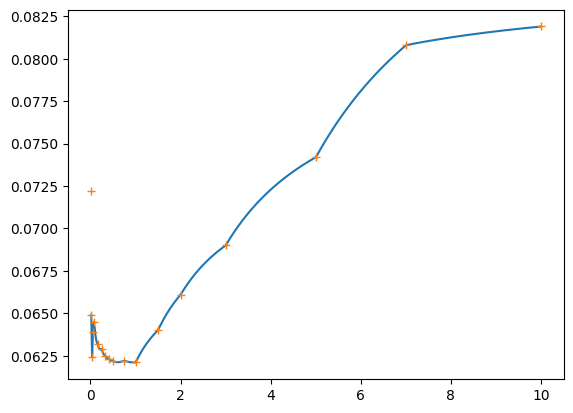

In [7]:
plt.plot(expiries, interpolated_vols)
plt.plot(vols_atm_mkt_expiries, vols_atm_mkt, "+")
plt.show()

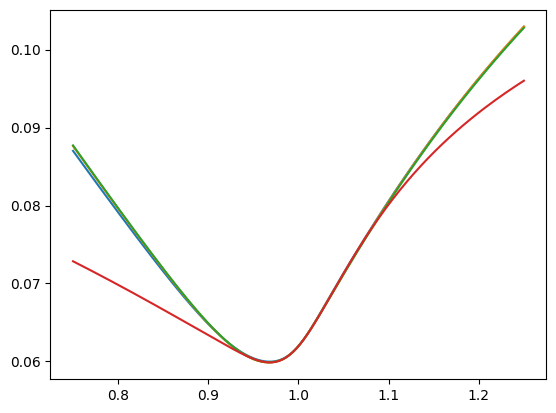

In [8]:
plt.plot(strike_ratio, vol_call_put)
plt.plot(strike_ratio, vol_instrument)
plt.plot(strike_ratio, vol_delta)
plt.plot(strike_ratio, vol_svi)
plt.show()

In [9]:
fxVolatilityInterpolationConfig.write_to_json(
    "fxVolatilityInterpolationConfig.json", interpolation_config
)
fxVolatilityQuadraticSmile.write_to_json(
    "fxVolatilityQuadraticSmile.json", fx_volatility_instrument
)
fxVolatilityCalibrationTargets.write_to_json(
    "fxVolatilityCalibrationTargets.json", volatility_targets
)

In [10]:
obj1 = fxVolatilityInterpolationConfig.read_from_json(
    "fxVolatilityInterpolationConfig.json"
)
obj2 = fxVolatilityQuadraticSmile.read_from_json("fxVolatilityQuadraticSmile.json")
obj3 = fxVolatilityCalibrationTargets.read_from_json(
    "fxVolatilityCalibrationTargets.json"
)